# ODD 2025 - Py013

## Instalação dos pacotes necessários e criação de constantes

In [1]:
import pdfplumber
import re
import pandas as pd
import matplotlib.pyplot as plt
from unidecode import unidecode
from collections import defaultdict
from os import listdir

# Caminho do arquivo PDF e Excel
pasta_dados = 'Result_Concursos'
arquivo_excel = "servidores_santos.xlsx"

# Expressões regulares para extração
regex_clasificacao_especial = re.compile(r'(COMO PESSOA (.+?) [\(–])|(RESERVADAS (.+?)\r?\n)', flags=re.IGNORECASE)
regex_linha_candidato = re.compile(r"\d?\s?\d{9,10}\s([A-ZÀ-ÿ\s]+)\s.+\s(\d+)\s+HABILITADO\r?\n?", flags=re.IGNORECASE)
regex_linhas_por_cargo = re.compile(r"((?:\d?\s?\d{9,10}.+?(\n|$))+)")
str_regex_nome_cargo = r"(Função:|Cargo) .+? - (.+?)\r?\n(\D\r?\n?)*?(CLASSIFICAÇÃO|SITUAÇÃO|SITUAÇÃO\r?\nPROFISSIONAL|MENORES)\r?\n"

## Extraindo dados dos PDFs de classificações:

In [7]:
dados_extraidos = []

# Abrindo o PDF e extraindo os dados
for file in listdir(pasta_dados):
    if file.endswith(".pdf"):
        # print(file)
        with pdfplumber.open(pasta_dados + '/' + file) as pdf:
            for pagina in pdf.pages:
                texto_pagina = pagina.extract_text().upper()
                if texto_pagina:
                    classificacao_especial = re.search(regex_clasificacao_especial, texto_pagina)
                    for grupo_funcao in regex_linhas_por_cargo.finditer(texto_pagina):
                        bloco_profissional = grupo_funcao.group(1)
                        primeira_matricula = bloco_profissional[:10]
                        try: nome_cargo = re.compile(str_regex_nome_cargo + primeira_matricula.strip(), flags=re.IGNORECASE).search(texto_pagina).group(2)
                        except: continue # Não é uma listagem de convocados
                        for convocado in regex_linha_candidato.findall(bloco_profissional, re.IGNORECASE):
                            dados_extraidos.append({
                                "Cargo_Edital": nome_cargo + ('_' + classificacao_especial.group(0) if classificacao_especial else '').replace('\n',''),
                                "Classificação": int(convocado[1]),
                                "Nome": convocado[0].strip()
                            })

# Exibir os dados extraídos
for item in dados_extraidos:
    print(item)


{'Cargo_Edital': 'OFICIAL DE ADMINISTRAÇÃO', 'Classificação': 1, 'Nome': 'WAGNER ROCHA SANTOS'}
{'Cargo_Edital': 'OFICIAL DE ADMINISTRAÇÃO', 'Classificação': 2, 'Nome': 'JHON WESLEY DE JESUS RODRIGUES'}
{'Cargo_Edital': 'OFICIAL DE ADMINISTRAÇÃO', 'Classificação': 3, 'Nome': 'EDGAR LOPES MENDONÇA'}
{'Cargo_Edital': 'OFICIAL DE ADMINISTRAÇÃO', 'Classificação': 4, 'Nome': 'ANA CAROLINA MACEDO DE OLIVEIRA'}
{'Cargo_Edital': 'OFICIAL DE ADMINISTRAÇÃO', 'Classificação': 5, 'Nome': 'ADRYANE DOS SANTOS PAULINO'}
{'Cargo_Edital': 'OFICIAL DE ADMINISTRAÇÃO', 'Classificação': 6, 'Nome': 'MARCELLA BEATRIZ LEÃO SANTIAGO'}
{'Cargo_Edital': 'OFICIAL DE ADMINISTRAÇÃO', 'Classificação': 7, 'Nome': 'LUCAS SANTANA LOPES DOS SANTOS'}
{'Cargo_Edital': 'OFICIAL DE ADMINISTRAÇÃO', 'Classificação': 8, 'Nome': 'CAMILLA JESUS DA ROCHA'}
{'Cargo_Edital': 'OFICIAL DE ADMINISTRAÇÃO', 'Classificação': 9, 'Nome': 'DEONEL FELIX MANDU IZAQUE'}
{'Cargo_Edital': 'OFICIAL DE ADMINISTRAÇÃO', 'Classificação': 10, 'Nome': 

## Carregando relação de servidores xlsx e cruzando dados:

In [8]:
# Carregar a planilha
df = pd.read_excel(arquivo_excel, dtype=str)

# Nomes da coluna B da planilha (índice 1, pois começa do 0)
nomes_excel = set(df.iloc[:, 1].dropna().str.upper().apply(unidecode).str.strip()) # Convertendo para maiúsculas, removendo espaços extras

# Dicionários de cargo e salário
coluna_salario_base = df.columns[4]
coluna_cargo = df.columns[0]
df["Salario_Base"] = pd.to_numeric(df[coluna_salario_base], errors="coerce")  # Para número
salarios = dict(zip(df.iloc[:, 1].str.upper().apply(unidecode).str.strip(), df["Salario_Base"]))
cargos = dict(zip(df.iloc[:, 1].str.upper().apply(unidecode).str.strip(), df[coluna_cargo]))

# Filtrar os candidatos e adicionar o salário
dados_filtrados = [
    {**dado,
    #"Salario_Base": salarios.get(unidecode(dado["Nome"].upper()), 0),
    "Cargo_Atual": cargos.get(unidecode(dado["Nome"].upper()), 0)}
    for dado in dados_extraidos if unidecode(dado["Nome"].upper()) in nomes_excel
    and cargos.get(unidecode(dado["Nome"].upper()), 0) != 'ESTAGIÁRIO'
    and cargos.get(unidecode(dado["Nome"].upper()), 0)[:4] == unidecode(dado["Cargo_Edital"][:4])
]

# Filtrando pessoas que estão em mais de uma lista por cargo
# Um convocado por PCD por exemplo aparecerá também na lista de convocados normais em uma classificação geralmente mais baixa, não interessa para nossa futura estatística
nomes_com_variacao = defaultdict(set)
for item in dados_filtrados:
    if "_" in item["Cargo_Edital"]:
        cargo_base = item["Cargo_Edital"].split("_")[0]  # Removendo a parte especial
        nomes_com_variacao[cargo_base].add(item["Nome"])

dados_filtrados_sem_duplicados = [
    item for item in dados_filtrados 
    if "_" in item["Cargo_Edital"] or item["Nome"] not in nomes_com_variacao[item["Cargo_Edital"]]
]

# Exibir os dados filtrados
for dado in dados_filtrados_sem_duplicados:
    print(dado)

{'Cargo_Edital': 'OFICIAL DE ADMINISTRAÇÃO', 'Classificação': 1, 'Nome': 'WAGNER ROCHA SANTOS', 'Cargo_Atual': 'OFICIAL DE ADMINISTRACAO'}
{'Cargo_Edital': 'OFICIAL DE ADMINISTRAÇÃO', 'Classificação': 3, 'Nome': 'EDGAR LOPES MENDONÇA', 'Cargo_Atual': 'OFICIAL DE ADMINISTRACAO'}
{'Cargo_Edital': 'OFICIAL DE ADMINISTRAÇÃO', 'Classificação': 7, 'Nome': 'LUCAS SANTANA LOPES DOS SANTOS', 'Cargo_Atual': 'OFICIAL DE ADMINISTRACAO'}
{'Cargo_Edital': 'OFICIAL DE ADMINISTRAÇÃO', 'Classificação': 10, 'Nome': 'JHONATAN WILLIAN RODRIGUES DA CRUZ', 'Cargo_Atual': 'OFICIAL DE ADMINISTRACAO'}
{'Cargo_Edital': 'OFICIAL DE ADMINISTRAÇÃO', 'Classificação': 11, 'Nome': 'ALEC GOULARTE DIMAS SANTANA', 'Cargo_Atual': 'OFICIAL DE ADMINISTRACAO'}
{'Cargo_Edital': 'OFICIAL DE ADMINISTRAÇÃO', 'Classificação': 12, 'Nome': 'ISABELA SANTOS GARCIA DA SILVA', 'Cargo_Atual': 'OFICIAL DE ADMINISTRACAO'}
{'Cargo_Edital': 'OFICIAL DE ADMINISTRAÇÃO', 'Classificação': 13, 'Nome': 'AMANDA MEDIME BARBOSA', 'Cargo_Atual': 'OF

## Agrupar dados por cargo, realizar contagens e outras operações

In [42]:
# Dicionário para armazenar os agrupamentos por cargo
agrupados = defaultdict(list)
for item in dados_filtrados_sem_duplicados:
    agrupados[item["Cargo_Edital"]].append(item)

# Criar um conjunto de dados agrupados válidos
dados_cargos_estatistica = []
for nome_cargo, lista in agrupados.items():
    # Número total de pessoas ativas
    pessoas_efetivadas = len(lista)
    
    # Número de convocados, descontando quaisquer pessoas que estão em outra lista especial e no meio da última "real" classificação
    # Na apresentação foi contada como a maior classificação do último chamado por também considerar pessoas de listas especiais como efetivadas
    convocados = max((int(item["Classificação"]) for item in lista), default=0)
    if not '_' in nome_cargo:
        convocados -= len([x for x in dados_filtrados if x["Cargo_Edital"] == nome_cargo and x not in lista and x["Classificação"] < convocados])

    # Calcular a porcentagem de desistências
    porcentagem_desistencia =  1 - ((pessoas_efetivadas / convocados) if convocados > 0 else 0)

    # Adicionar ao resultado
    dados_cargos_estatistica.append({
        "Cargo_Edital": nome_cargo,
        "Pessoas_efetivadas": pessoas_efetivadas,
        "Convocados": convocados,
        "Porcentagem_desistencia": round(porcentagem_desistencia, 2)  # Arredondar para 2 casas
    })

# Pode ser interessante para seu estudo unir os dados de todas listas de um tipo de cargo (normal, pcd etc) nos cálculos
# Abaixo assume que uma pessoa não se registrou em mais de uma lista especial
# for item in dados_cargos_estatistica:
#     cargo_base = item["Cargo_Edital"].split("_")[0]
#     estatistica_base = next((x for x in dados_cargos_estatistica if x["Cargo_Edital"] == cargo_base), None)
#     if '_' in item["Cargo_Edital"] and estatistica_base:
#         estatistica_base["Pessoas_efetivadas"] += item["Pessoas_efetivadas"]
#         estatistica_base["Convocados"] += item["Convocados"]

# Exibir o resultado
for item in dados_cargos_estatistica:
    print(item)

{'Cargo_Edital': 'OFICIAL DE ADMINISTRAÇÃO', 'Pessoas_efetivadas': 33, 'Convocados': 48, 'Porcentagem_desistencia': 0.31}
{'Cargo_Edital': 'MÉDICO ANESTESISTA', 'Pessoas_efetivadas': 2, 'Convocados': 4, 'Porcentagem_desistencia': 0.5}
{'Cargo_Edital': 'MÉDICO GENERALISTA – SAÚDE DA FAMÍLIA', 'Pessoas_efetivadas': 15, 'Convocados': 48, 'Porcentagem_desistencia': 0.69}
{'Cargo_Edital': 'MÉDICO GINECOLOGISTA – AMBULATÓRIO', 'Pessoas_efetivadas': 9, 'Convocados': 17, 'Porcentagem_desistencia': 0.47}
{'Cargo_Edital': 'MÉDICO HOMEOPATA', 'Pessoas_efetivadas': 1, 'Convocados': 1, 'Porcentagem_desistencia': 0.0}
{'Cargo_Edital': 'MÉDICO INTENSIVISTA', 'Pessoas_efetivadas': 3, 'Convocados': 6, 'Porcentagem_desistencia': 0.5}
{'Cargo_Edital': 'MÉDICO MASTOLOGISTA', 'Pessoas_efetivadas': 1, 'Convocados': 1, 'Porcentagem_desistencia': 0.0}
{'Cargo_Edital': 'MÉDICO MEDICINA DO TRABALHO', 'Pessoas_efetivadas': 3, 'Convocados': 5, 'Porcentagem_desistencia': 0.4}
{'Cargo_Edital': 'MÉDICO NEONATOLOGIST

## Visualizações gráficas

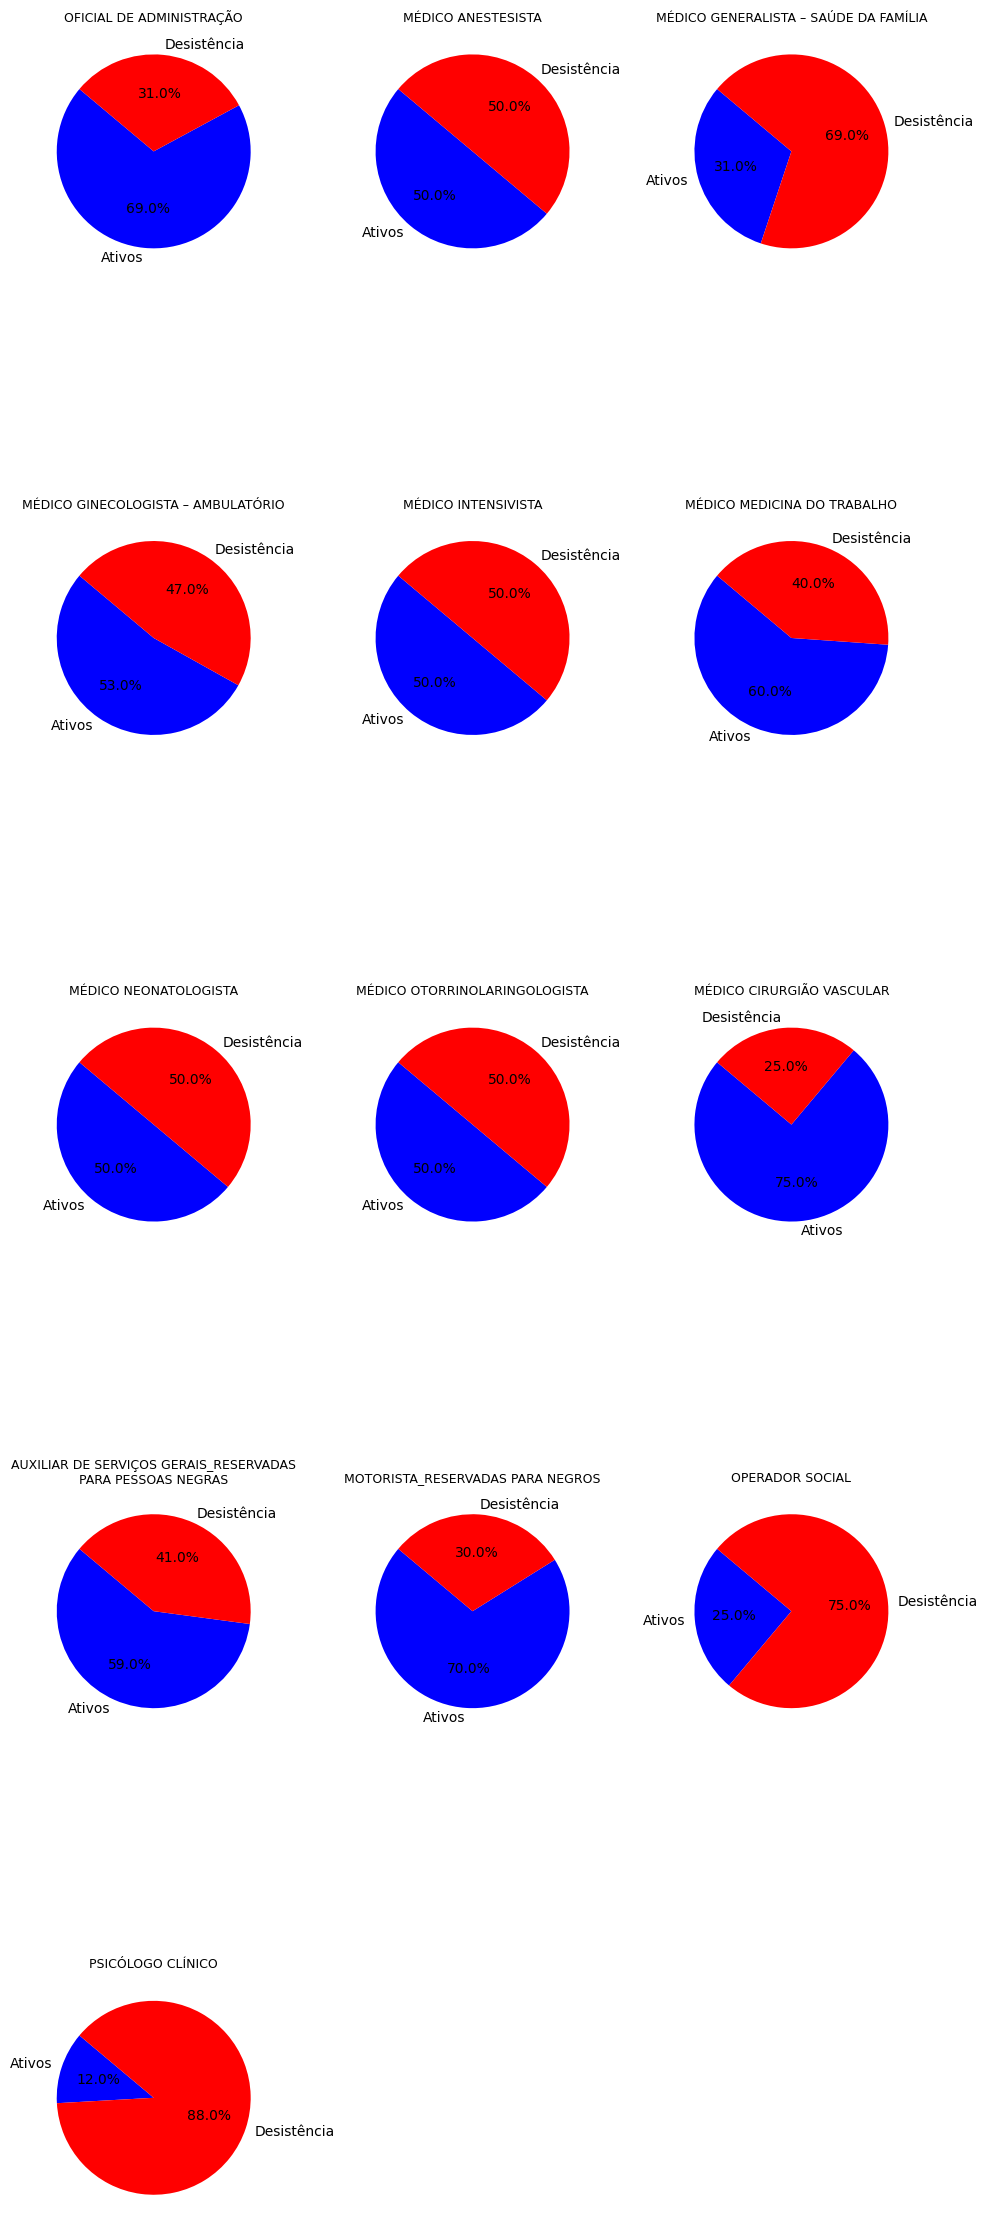

In [43]:
# Cópia da lista de estatisticas sem cargos com 3 ou menos pessoas chamadas
dados_cargos_estatistica_filtrados = [item for item in dados_cargos_estatistica if item["Convocados"] > 3]

# Gráficos de pizza lado a lado
num_graficos = len(dados_cargos_estatistica_filtrados)
num_colunas = 3
num_linhas = (num_graficos + num_colunas - 1) // num_colunas

fig, axes = plt.subplots(num_linhas, num_colunas, figsize=(10, 5 * num_linhas))
axes = axes.flatten()

for i, item in enumerate(dados_cargos_estatistica_filtrados):
    labels = ['Ativos', 'Desistência']
    sizes = [1 - item['Porcentagem_desistencia'], item['Porcentagem_desistencia']]
    colors = ['blue', 'red']
    axes[i].pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, startangle=140)
    axes[i].set_title(item['Cargo_Edital'], fontsize=9, wrap=True)

# Esconder eixos vazios se o número de gráficos for ímpar
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()